In [1]:
import sys; sys.path.append('/Users/brandonliu/Documents/Parkes/transitive-trust-models')
import numpy as np
import matplotlib.pyplot as plt
import studies.efficiency as e; reload(e);
import strategic_trust_models as stm; reload(stm);
from trust_graph import TrustGraph
import operator as op
import time
import math
from scipy import stats
import random
import hitting_time.mat_hitting_time as mht
import random
from collections import defaultdict

In [18]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['font.size'] = 21
plt.rcParams['legend.fontsize'] = 16
# plt.rcParams['lines.markersize'] = 7.5
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 1.5

In [3]:
from IPython.parallel import Client
cli = Client()
lview = cli.load_balanced_view()

In [4]:
MECHANISMS = [
    (True, 'Global PageRank', stm.global_pagerank, True, True, 0.8),
    (False, 'Personalized PageRank', stm.person_pagerank, True, True, 0.8),
    (True, 'Global Hitting Time', stm.global_hitting_time, True, True, 0.8),
    (False, 'Personalized Hitting Time', stm.person_hitting_time, True, True, 0.8),
    (True, 'Average Score', stm.average_ratings, True, True, 0.8),
]

In [5]:
@lview.parallel(block=True)
def one_compute_mechanism(args):
    import sys
    sys.path.append('..')
    import studies.efficiency as e; reload(e)
    import strategic_trust_models as stm; reload(stm)
    import networkx as nx
    import random
    from scipy import stats
    import numpy as np
    
    MECHANISMS = [
        (True, 'Global PageRank', stm.global_pagerank),
        (False, 'Personalized PageRank', stm.person_pagerank),
        (True, 'Global Hitting Time', stm.global_hitting_time),
        (False, 'Personalized Hitting Time', stm.person_hitting_time),
        (True, 'Average Score', stm.average_ratings),
    ]
    
    graph, mech_index, sybil_pct, cutlinks, gensybils = args
    is_global, name, func = MECHANISMS[mech_index]
    
    base_scores = func(graph, 0, sybil_pct)
    if is_global:
        base_scores = stats.rankdata(base_scores)
    else:
        for i in xrange(base_scores.shape[0]):
            base_scores[i] = stats.rankdata(base_scores[i])
            
    rank_changes = []
    N = len(graph)
    for agent in xrange(N):
        scores = func(graph, 1, sybil_pct, cutlinks, gensybils, strategic_agents=[agent])
        if is_global:
            scores = stats.rankdata(scores[:N])
            rank_changes.append(([base_scores[agent]], [scores[agent]]))
        else:
            ranks = np.zeros((N, N))
            for i in xrange(scores.shape[0]):
                ranks[i] = stats.rankdata(scores[i, :N])
            rank_changes.append((
                [base_scores[i, agent] for i in xrange(N) if i != agent],
                [ranks[i, agent] for i in xrange(N) if i != agent]
            ))
    
    return {
        'mech_index': mech_index,
        'name': name,
        'is_global': is_global,
#         'agent_types': graph.agent_types,
#         'edges': nx.to_numpy_matrix(graph),
        'sybil_pct': sybil_pct,
        'cutlinks': cutlinks,
        'gensybils': gensybils,
        'rank_changes': rank_changes
    }
        

In [14]:
start = time.time()

N = 3
graphs = [TrustGraph(100, 'uniform', 'cluster', 20, 'sample', 8) for _ in xrange(N)]
# args = [[[g, i, m[5], True, False] for g in graphs] for i, m in enumerate(MECHANISMS)]
args = [[[g, i, 0.8, True, False] for g in graphs] for i, m in enumerate(MECHANISMS)]
flattened_args = [val for arr in args for val in arr]
results_t8_cutlinks = one_compute_mechanism.map(flattened_args)

print 'elapsed:', time.time() - start

elapsed: 208.896057129


In [8]:
PLOT_PARAMS = [
    ('PageRank', '^', 'b', 0.25, True, 10),
    ('Personalized PageRank', '*', 'g', 0.2, True, 7),
    ('Global Hitting Time', 's', 'r', 0.25, True, 9),
    ('Personalized Hitting Time', 'o', 'c', 0.2, True, 6),
    ('Average Score', 'D', 'm', 0.25, True, 4),
]

def plot_rank_changes(results, delta=False, sybil_only=False, cutlinks_only=False, mechs=None):
    seen = set()
    
    import matplotlib.cm as cmx
    import matplotlib.colors as colors
    grayMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=(len(PLOT_PARAMS) - 1)),
                                 cmap=plt.get_cmap('gray'))
    
    if mechs is None:
        mechs = range(len(PLOT_PARAMS))
    
    vals = {i: defaultdict(list) for i in mechs}
    for res in results:
        for xs, ys in res['rank_changes']:
            for x, y in zip(xs, ys):
                vals[res['mech_index']][x].append((y - x) if delta else y)
    
    mins = {i: [(np.min(vals[i][j+1]) if len(vals[i][j+1]) > 0 else None) for j in range(100)] for i in mechs}
    lines = {i: [(np.mean(vals[i][j+1]) if len(vals[i][j+1]) > 0 else None) for j in range(100)] for i in mechs}
    maxs = {i: [(np.max(vals[i][j+1]) if len(vals[i][j+1]) > 0 else None) for j in range(100)] for i in mechs}
    
#     print lines
    
    for m in mechs:
        p = PLOT_PARAMS[m]
#         plt.plot(np.arange(100) + 1, mins[m], '-', c=p[2], zorder=p[5])
#         plt.plot(np.arange(100) + 1, maxs[m], '-', c=p[2], zorder=p[5])
#         mask = np.arange((m + 2) % len(mechs), 100, len(mechs))
        if p[0] in ['PageRank', 'Global Hitting Time']:
            mask = np.arange(m, 100, 4)
        else:
            mask = np.arange(0, 100, 2)
        plt.plot((np.arange(100) + 1)[mask], np.array(lines[m])[mask], p[1], c=p[2], zorder=p[5])
#         plt.plot((np.arange(100) + 1)[mask], np.array(mins[m])[mask], p[1], c=p[2], zorder=p[5])
#         plt.plot((np.arange(100) + 1)[mask], np.array(maxs[m])[mask], p[1], c=p[2], zorder=p[5])
#         for i, (mi, ma) in enumerate(zip(mins[m], maxs[m])):
#             if i in mask:
#                 plt.plot([i + 1, i + 1], [mi, ma], '-', c=p[2])
        
    
#     for res in results:
#         p = PLOT_PARAMS[res['mech_index']]
#         if res['mech_index'] in mechs and (not sybil_only or res['gensybils']) and (not cutlinks_only or res['gensybils']):
#             for xs, ys in res['rank_changes']:
#                 if delta:
#                     ys = [y - x for x, y in zip(xs, ys)]
#                 plt.plot(xs, ys, p[1], c=p[2], zorder=random.randrange(10),# alpha=p[3],
# #                 plt.plot(xs, ys, p[1], c=grayMap.to_rgba(res['mech_index']), zorder=p[5], # alpha=p[3],
#                      label=("_" if res['mech_index'] in seen else p[0]))
#     if delta:
#         plt.ylim([-5, 100])
    plt.xlabel('Old Rank')
    plt.ylabel('Change in Rank' if delta else 'New Rank')
    plt.margins(0.07)
    
    # Handle legend :(
    
    lines = [plt.Line2D((0, 0), (0, 0), c=p[2], linestyle='', marker=p[1]) for p in PLOT_PARAMS]
#     lines = [plt.Line2D((0, 0), (0, 0), c=grayMap.to_rgba(i), linestyle='', marker=p[1]) for i, p in enumerate(PLOT_PARAMS)]
    plt.legend(lines, [p[0] for p in PLOT_PARAMS], loc='best', numpoints=1)

    plt.show()

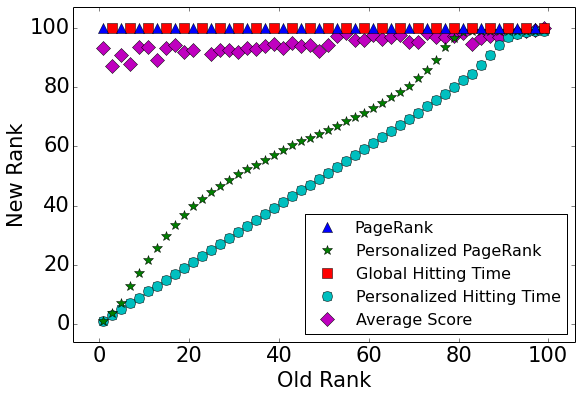

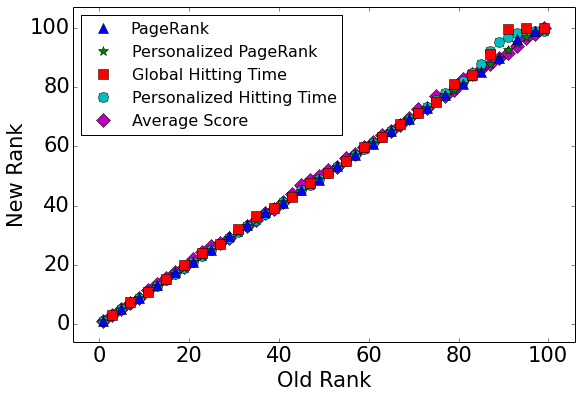

In [19]:
# 2015-09-13
plot_rank_changes(results_t8)
plot_rank_changes(results_t8_cutlinks)

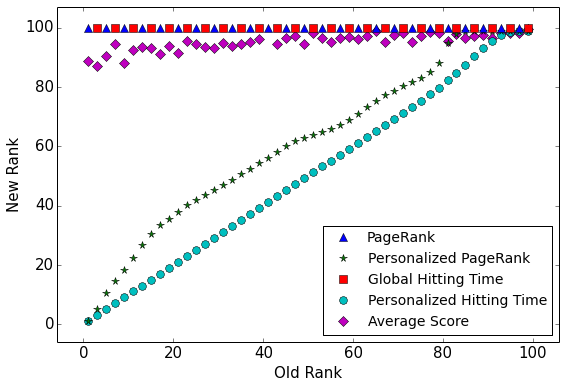

In [17]:
plot_rank_changes(results_at_fixed)

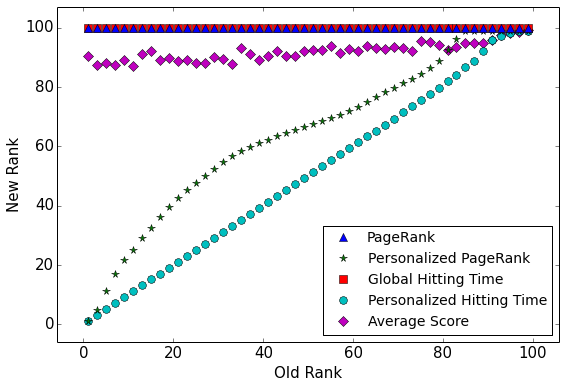

In [24]:
plot_rank_changes(results_ght_fixed)

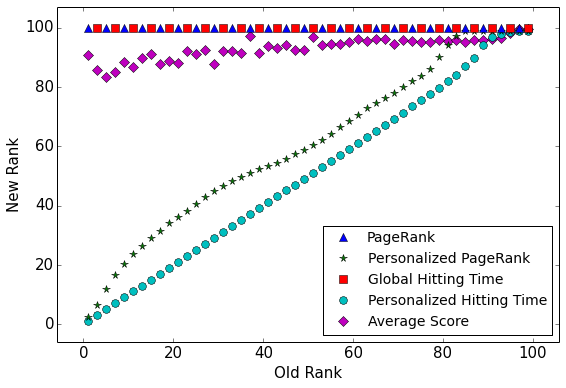

In [29]:
plot_rank_changes(results_t32)

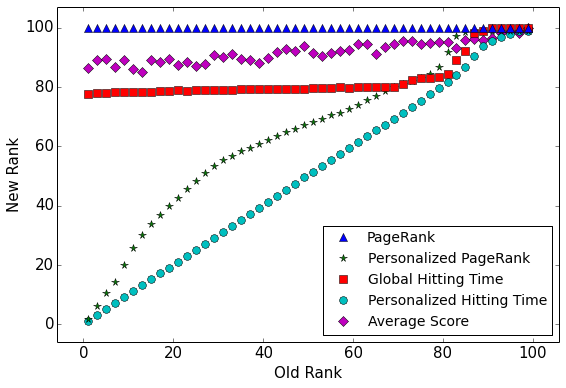

In [103]:
plot_rank_changes(results_a_3)

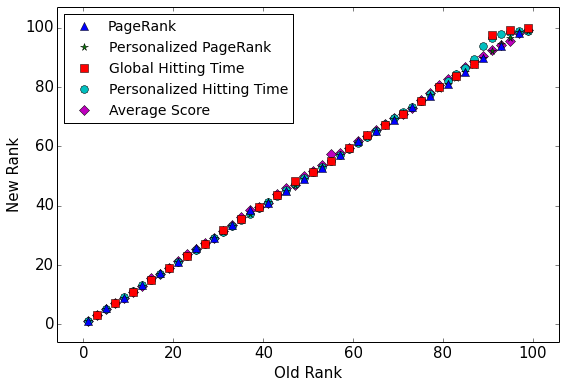

In [19]:
plot_rank_changes(results_at_fixed_cutlinks)

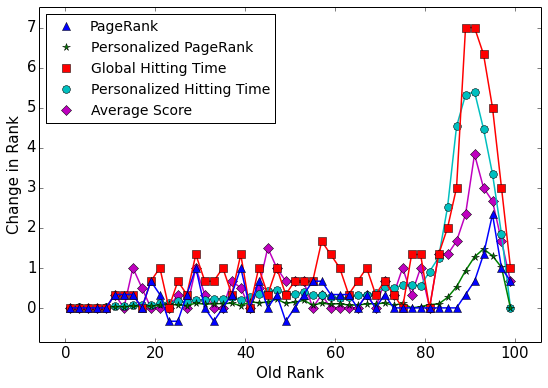

In [26]:
plot_rank_changes(results_b_3, True)

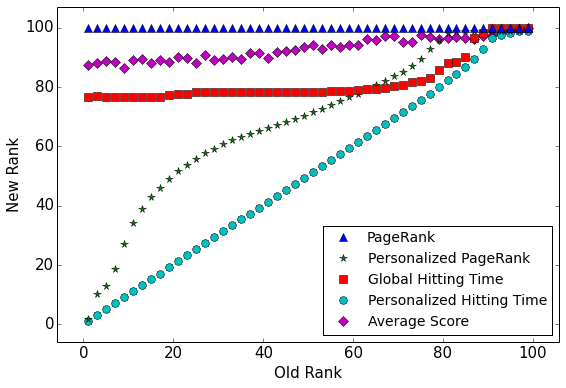

In [23]:
plot_rank_changes(results_c_3)

In [110]:
for i, m in enumerate(MECHANISMS):
    print m[1], np.mean([np.mean([np.array(x[1]) - np.array(x[0]) for x in r['rank_changes']])
                                      for r in results_a_3 if r['mech_index'] == i])

print

for i, m in enumerate(MECHANISMS):
    print m[1], np.mean([np.mean([np.array(x[1]) - np.array(x[0]) for x in r['rank_changes']])
                                      for r in results_b_3 if r['mech_index'] == i])
    
# for r in results2:
#     print r['name'], np.mean([np.array(x[1]) - np.array(x[0]) for x in r['rank_changes']])

Global PageRank 49.5
Personalized PageRank 14.2978451178
Global Hitting Time 32.4433333333
Personalized Hitting Time 0.704208754209
Average Score 41.6

Global PageRank 0.363333333333
Personalized PageRank 0.20164983165
Global Hitting Time 1.14833333333
Personalized Hitting Time 0.769292929293
Average Score 0.541666666667
